H0 = Todo los tratamientos son iguales
H1 = Hay diferencia en los tratamientos

In [44]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import researchpy as rp
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import scikit_posthocs as sp

In [51]:
df = pd.read_csv("ensayo-productos-2.1.tsv", delimiter="\t")
df = df.astype({"TRATAMIENTO":'category', "COLOR":'category'}) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   TRATAMIENTO  400 non-null    category
 1   COLOR        400 non-null    category
 2   PESO         400 non-null    float64 
 3   CALIBRE      400 non-null    object  
 4   BRIX         400 non-null    int64   
dtypes: category(2), float64(1), int64(1), object(1)
memory usage: 10.6+ KB


In [32]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(10, 8)})


Text(0.5, 1.0, 'CALIBRE')

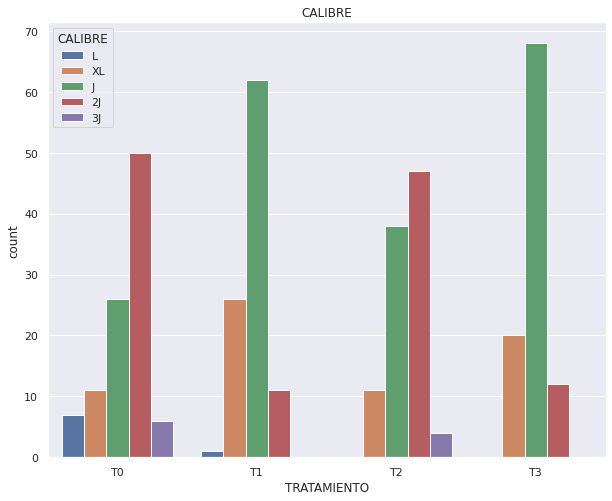

In [34]:
plot1 = sns.countplot(data=df, x='TRATAMIENTO', hue='CALIBRE')
plot1.set_title("CALIBRE")

In [49]:
#Fynciones para normalizar datos

def getCalibre(x):
    if x == 'L':
        return round(random.uniform(22,24), 1)
    if x == 'XL':
        return round(random.uniform(24,26), 1)
    if x == 'J':
        return round(random.uniform(26,28), 1)
    if x == '2J':
        return round(random.uniform(28,30), 1)
    if x == '3J':
        return round(random.uniform(30,32), 1)
    if x == '4J':
        return round(random.uniform(32,34), 1)

def getColor(x):
    if x == 'Blanca':
        return 1
    if x == 'Clara':
        return 2
    if x == 'Oscura':
        return 3

In [52]:
df['CALIBRE'] = df.CALIBRE.apply(func=getCalibre)
df.to_csv("ensayo-productos-2_2.tsv", sep="\t")
df.groupby('TRATAMIENTO')['CALIBRE'].describe()
#df1['COLOR'] = df1.COLOR.apply(func=getColor)

/tmp/ipykernel_39202/2307853771.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('TRATAMIENTO')['CALIBRE'].describe()


,count,mean,std,min,25%,50%,75%,max
TRATAMIENTO,,,,,,,,
T0,100.0,27.812,2.066240,22.3,26.600,28.30,29.325,31.8
T1,100.0,26.680,1.398990,22.9,25.875,26.90,27.600,30.0
T2,100.0,27.854,1.612165,24.2,26.600,28.05,28.875,31.8
T3,100.0,26.917,1.242843,24.1,26.250,27.10,27.700,29.9


Text(0, 0.5, 'Peso en gramos')

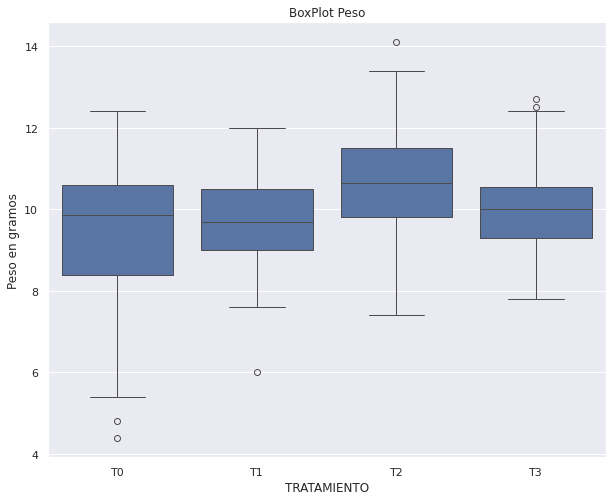

In [28]:
plot3 = sns.boxplot(data=df, x="TRATAMIENTO", y="PESO")
plot3.set_title("BoxPlot Peso")
plot3.set_ylabel("Peso en gramos")

<Axes: xlabel='TRATAMIENTO', ylabel='PESO'>

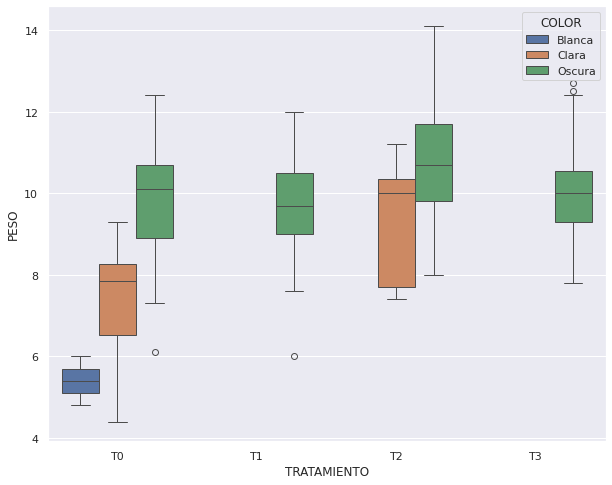

In [53]:
sns.boxplot(data=df, x="TRATAMIENTO", y="PESO", hue='COLOR')

Los datos no presentan un distribucion normal - p = 6.159799522720277e-05


ShapiroResult(statistic=0.991379976272583, pvalue=0.01987716369330883)

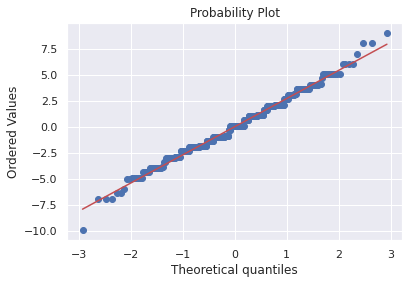

In [9]:
#Revisar si valores distribuyen normal
data = df['PESO'].to_numpy()
alpha = 0.05
w, p = stats.shapiro(data)

if p > alpha:
    print(f"Los datos presentan un distribucion normal - p = {p}")
else:
    print(f"Los datos no presentan un distribucion normal - p = {p}")

#Statsmodel
fig = plt.figure()
ax = fig.add_subplot(111)

mod = ols('BRIX ~ C(TRATAMIENTO)', data=df).fit()

qp = stats.probplot(mod.resid, dist='norm', plot=ax)

stats.shapiro(mod.resid)


In [10]:

tratamientos = df.groupby('TRATAMIENTO', observed=False )
T0 = tratamientos.get_group('T0')
T1 = tratamientos.get_group('T1')
T2 = tratamientos.get_group('T2')
T3 = tratamientos.get_group('T3')

In [12]:
 #Si los datos distribuyen normal
#STATSMODEl
columna = 'CALIBRE'
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)
mc = MultiComparison( df[columna], df['TRATAMIENTO'])
result = mc.tukeyhsd(0.05)
print(result.summary())

#STAS
stats.f_oneway(T0[columna],T1[columna],T2[columna],T3[columna])
result = stats.tukey_hsd(T0[columna],T1[columna],T2[columna],T3[columna])
print(result)

                   sum_sq     df         F        PR(>F)
C(TRATAMIENTO)  1868.1875    3.0  84.06624  4.204930e-42
Residual        2933.4100  396.0       NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    T0     T1    -1.11    0.0 -1.6868 -0.5332   True
    T0     T2    0.102 0.9684 -0.4748  0.6788  False
    T0     T3    -0.91 0.0003 -1.4868 -0.3332   True
    T1     T2    1.212    0.0  0.6352  1.7888   True
    T1     T3      0.2 0.8076 -0.3768  0.7768  False
    T2     T3   -1.012    0.0 -1.5888 -0.4352   True
----------------------------------------------------
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      1.110     0.000     0.533     1.687
 (0 - 2)     -0.102     0.968    -0.679     0.475
 (0 - 3)      0.910     0.000     0.333     1.487
 (1 - 0)     -1.110     0.000  

In [17]:
#Si la distribucion no es normal
stats.kruskal(T0[columna],T1[columna],T2[columna],T3[columna])
pvalue = sp.posthoc_dunn([T0[columna],T1[columna],T2[columna],T3[columna]], p_adjust="bonferroni")
print(pvalue)
print(pvalue < alpha)


              1             2             3         4
1  1.000000e+00  4.798112e-07  1.000000e+00  0.000056
2  4.798112e-07  1.000000e+00  5.022671e-07  1.000000
3  1.000000e+00  5.022671e-07  1.000000e+00  0.000058
4  5.598200e-05  1.000000e+00  5.816655e-05  1.000000
       1      2      3      4
1  False   True  False   True
2   True  False   True  False
3  False   True  False   True
4   True  False   True  False


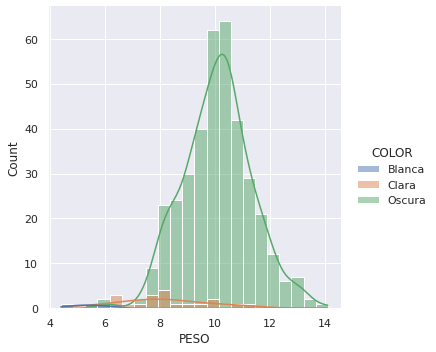

In [18]:
sns.displot(data=df, x="PESO", hue="COLOR", kde=True)

In [19]:
mod = ols('PESO ~ TRATAMIENTO + COLOR ', data=df).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
TRATAMIENTO,72.155709,3.0,16.654862,3.309097e-10
COLOR,137.202915,2.0,47.503427,3.293907e-19
Residual,568.989985,394.0,NaN,NaN


In [20]:
mc = MultiComparison( df['COLOR'], df['TRATAMIENTO'])
result = mc.tukeyhsd(0.05)
result.summary()

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

In [21]:
rp.summary_cont(df['CALIBRE'].groupby(df['TRATAMIENTO']))

/tmp/ipykernel_39202/2104533937.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rp.summary_cont(df['CALIBRE'].groupby(df['TRATAMIENTO']))


,N,Mean,SD,SE,95% Conf.,Interval
TRATAMIENTO,,,,,,
T0,100,27.765,2.0389,0.2039,27.3604,28.1696
T1,100,26.655,1.2815,0.1282,26.4007,26.9093
T2,100,27.867,1.6371,0.1637,27.5422,28.1918
T3,100,26.855,1.2312,0.1231,26.6107,27.0993


In [42]:
stats.f_oneway(df['PESO'][df['TRATAMIENTO'] == 'T0'],
               df['PESO'][df['TRATAMIENTO'] == 'T3L'],
               df['PESO'][df['TRATAMIENTO'] == 'T6L'],
               df['PESO'][df['TRATAMIENTO'] == 'T9L'],
               df['PESO'][df['TRATAMIENTO'] == 'T12L'],
               )

F_onewayResult(statistic=30.379816030660848, pvalue=1.2591476581296452e-22)

In [43]:
result = stats.tukey_hsd(df['PESO'][df['TRATAMIENTO'] == 'T0'],
               df['PESO'][df['TRATAMIENTO'] == 'T3L'],
               df['PESO'][df['TRATAMIENTO'] == 'T6L'],
               df['PESO'][df['TRATAMIENTO'] == 'T9L'],
               df['PESO'][df['TRATAMIENTO'] == 'T12L'],)

In [44]:
print(result)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.163     0.948    -0.769     0.443
 (0 - 2)     -0.158     0.953    -0.764     0.448
 (0 - 3)     -0.228     0.841    -0.834     0.378
 (0 - 4)     -2.056     0.000    -2.662    -1.450
 (1 - 0)      0.163     0.948    -0.443     0.769
 (1 - 2)      0.005     1.000    -0.601     0.611
 (1 - 3)     -0.065     0.998    -0.671     0.541
 (1 - 4)     -1.893     0.000    -2.499    -1.287
 (2 - 0)      0.158     0.953    -0.448     0.764
 (2 - 1)     -0.005     1.000    -0.611     0.601
 (2 - 3)     -0.070     0.998    -0.676     0.536
 (2 - 4)     -1.898     0.000    -2.504    -1.292
 (3 - 0)      0.228     0.841    -0.378     0.834
 (3 - 1)      0.065     0.998    -0.541     0.671
 (3 - 2)      0.070     0.998    -0.536     0.676
 (3 - 4)     -1.828     0.000    -2.434    -1.222
 (4 - 0)      2.056     0.000     1.450     2.662
 (4 - 1)      1.893     0.000   

In [45]:
T12L

,TRATAMIENTO,COLOR,PESO,CALIBRE,BRIX
400,T12L,Clara,8.9,J,16
401,T12L,Clara,7.3,XL,15
402,T12L,Clara,8.3,J,18
403,T12L,Clara,8.9,J,15
404,T12L,Clara,10.0,2J,16
...,...,...,...,...,...
495,T12L,Oscura,12.5,3J,18
496,T12L,Oscura,12.9,3J,18
497,T12L,Oscura,9.1,J,22
498,T12L,Oscura,10.8,2J,21


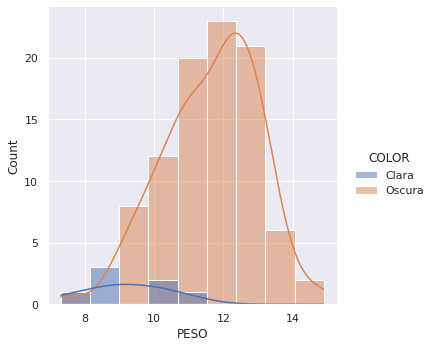

In [46]:
sns.displot(data=T12L, x="PESO", hue="COLOR", kde=True)

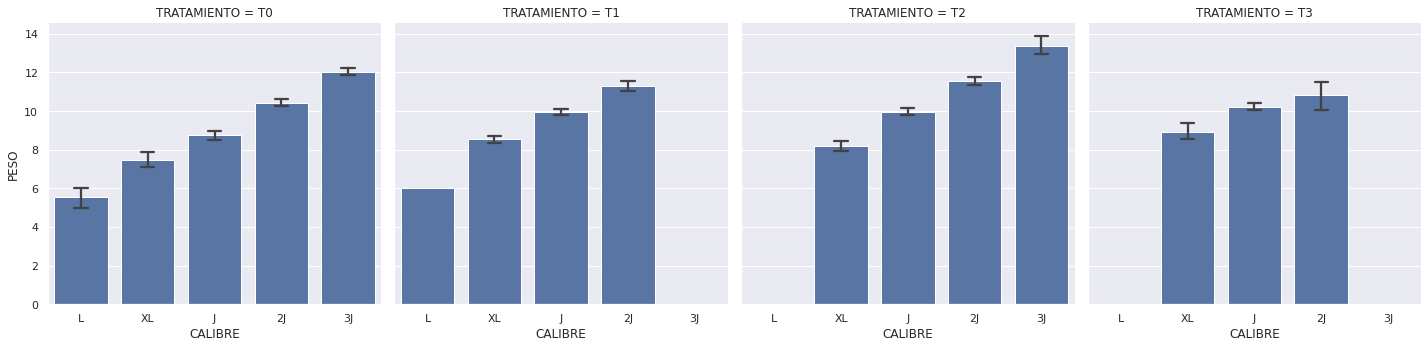

In [39]:
sns.catplot(df, kind="bar", x='CALIBRE', y="PESO", col="TRATAMIENTO", capsize=.2)

Text(0, 0.5, 'Peso en gramos')

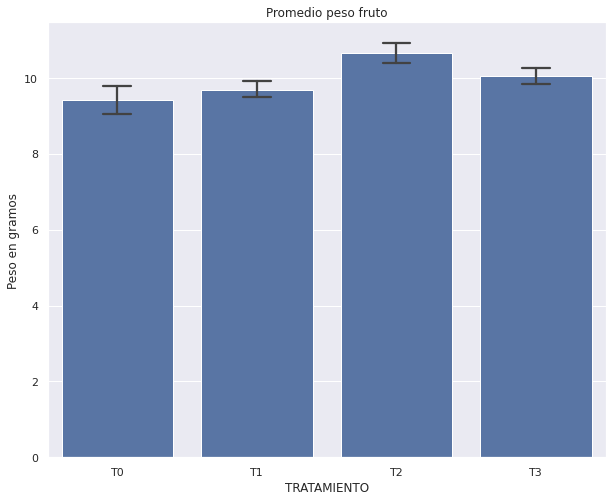

In [56]:
plot2 = sns.barplot(data=df, x='TRATAMIENTO', y='PESO', capsize=.2)
plot2.set_title("Promedio peso fruto")
plot2.set_ylabel("Peso en gramos")